# Initialization

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
sns.set_context('talk')

# Load data

In [4]:
train = pd.read_pickle('train')

# Prepare data

In [5]:
# Target is whether the virus is detected
y = pd.to_numeric(train.WnvPresent.values)

In [6]:
# Remove unusable features from dataset
X = train.drop(
    ['Date', 'Trap', 'NumMosquitos', 'WnvPresent', 'Species', 'Zone'], axis=1)

In [7]:
# list of one hot feature names, to exclude from standardizaion
one_hots = [
    'CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Zone1',
    'Zone2', 'Zone3', 'Zone4', 'Zone5', 'Zone6', 'Zone8', 'Zone12', 'TS', 'FG',
    'Jun', 'Jul', 'Aug', 'Sep', 'Oct', '2009', '2011', '2013'
]

In [8]:
# Remove one hot variables, then use a standard scaler on the
# remaining features, and join them back together
Xscaler = StandardScaler()

X_sc = Xscaler.fit_transform(X.drop(one_hots, axis=1))
X_sc = pd.DataFrame(X_sc, columns=[X.drop(one_hots, axis=1).columns])
X_one_hots = X[one_hots]

X_all = X_sc.join(X_one_hots)

In [9]:
# Split data preserving label ratio
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_all), np.array(y), random_state=42, stratify=y)

In [10]:
# Use borderline SMOTE to fix class imbalance
X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X_train,
                                                                y_train)

# Neural Network

In [127]:
# Define nework in function for use in the skikit wrapper
def create_baseline():
    model = Sequential()
    model.add(Dense(30, input_dim=59, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    adam_op = Adam(lr=0.001)

    model.compile(
        loss='binary_crossentropy', optimizer=adam_op, metrics=['accuracy'])
    return model


# Buld model within scikit wrapper
estimator = KerasClassifier(
    build_fn=create_baseline, nb_epoch=200, batch_size=10, verbose=0)

# Callback to save the model with the least loss on the validation data
checkpointer = ModelCheckpoint(
    filepath="weights.hdf5", verbose=1, save_best_only=True)

# Fit the data
estimator.fit(
    X_resampled,
    y_resampled,
    validation_data=(X_test, y_test),
    callbacks=[checkpointer],
    epochs=100,
    verbose=2)

Train on 14932 samples, validate on 2627 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.44073, saving model to weights.hdf5
2s - loss: 0.4540 - acc: 0.7943 - val_loss: 0.4407 - val_acc: 0.7693
Epoch 2/100
Epoch 00001: val_loss improved from 0.44073 to 0.41326, saving model to weights.hdf5
1s - loss: 0.3865 - acc: 0.8333 - val_loss: 0.4133 - val_acc: 0.7880
Epoch 3/100
Epoch 00002: val_loss did not improve
1s - loss: 0.3614 - acc: 0.8450 - val_loss: 0.4185 - val_acc: 0.7807
Epoch 4/100
Epoch 00003: val_loss improved from 0.41326 to 0.34920, saving model to weights.hdf5
1s - loss: 0.3441 - acc: 0.8526 - val_loss: 0.3492 - val_acc: 0.8196
Epoch 5/100
Epoch 00004: val_loss did not improve
1s - loss: 0.3359 - acc: 0.8557 - val_loss: 0.4243 - val_acc: 0.7807
Epoch 6/100
Epoch 00005: val_loss improved from 0.34920 to 0.33170, saving model to weights.hdf5
1s - loss: 0.3230 - acc: 0.8645 - val_loss: 0.3317 - val_acc: 0.8405
Epoch 7/100
Epoch 00006: val_loss did not improve
1s 

Epoch 00066: val_loss did not improve
1s - loss: 0.2282 - acc: 0.9131 - val_loss: 0.3660 - val_acc: 0.8641
Epoch 68/100
Epoch 00067: val_loss did not improve
1s - loss: 0.2263 - acc: 0.9153 - val_loss: 0.3618 - val_acc: 0.8656
Epoch 69/100
Epoch 00068: val_loss did not improve
1s - loss: 0.2301 - acc: 0.9123 - val_loss: 0.3659 - val_acc: 0.8576
Epoch 70/100
Epoch 00069: val_loss did not improve
1s - loss: 0.2290 - acc: 0.9129 - val_loss: 0.3707 - val_acc: 0.8618
Epoch 71/100
Epoch 00070: val_loss did not improve
1s - loss: 0.2317 - acc: 0.9117 - val_loss: 0.3898 - val_acc: 0.8588
Epoch 72/100
Epoch 00071: val_loss did not improve
1s - loss: 0.2304 - acc: 0.9115 - val_loss: 0.3681 - val_acc: 0.8710
Epoch 73/100
Epoch 00072: val_loss did not improve
1s - loss: 0.2269 - acc: 0.9141 - val_loss: 0.3769 - val_acc: 0.8595
Epoch 74/100
Epoch 00073: val_loss did not improve
1s - loss: 0.2278 - acc: 0.9154 - val_loss: 0.3745 - val_acc: 0.8671
Epoch 75/100
Epoch 00074: val_loss did not improve
1s

In [128]:
estimator.model.load_weights('weights.hdf5')

In [129]:
clf_probs = estimator.predict_proba(X_test)

In [130]:
sig_score = log_loss(y_test, clf_probs)

In [131]:
y_pred = estimator.predict(X_test)

# Metrics

In [132]:
# Log loss
print(sig_score)

0.321351492383


In [133]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.88      0.92      2489
          1       0.18      0.46      0.26       138

avg / total       0.93      0.86      0.89      2627



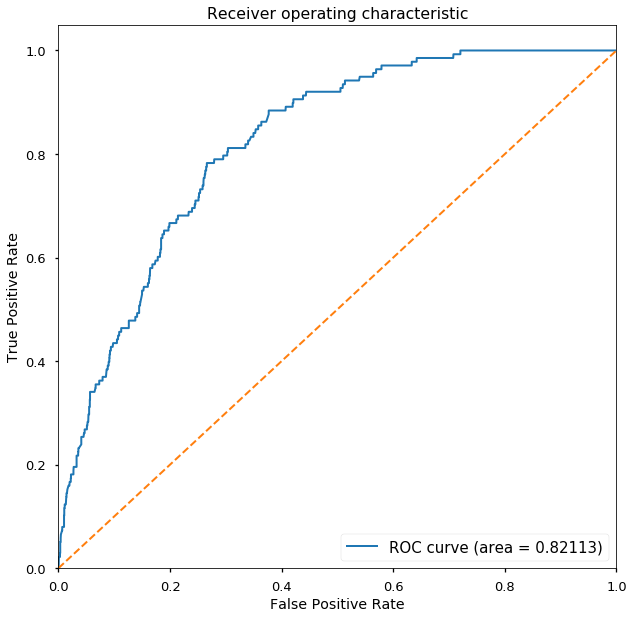

In [134]:
# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, clf_probs[:,1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 10))
lw = 2
ax.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
ax.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right", fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(join('plots', 'NN', 'ROC.png'))